![logo](../img/cems_header.png)

# Visualising the Fire Weather Index (FWI) for the European State of the Climate (ESOTC) assesment

<div class="alert alert-block alert-info">
<b>Note:</b> Data for this notebook were provided by the <a href="https://effis.jrc.ec.europa.eu">CEMS-EMS European Forest Fire Information System – EFFIS</a> of the European Commission Joint Research Centre. The data can be accessed through the Copernicus Climate Change Service, Climate Data Store, (2019): Fire danger indices historical data from the Copernicus Emergency Management Service. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: <a href="https://doi.org/10.24381/cds.0e89c522">10.24381/cds.0e89c522</a>. We require you to acknowledge the source if you use the data.
</div>

Wildfires develop where there is available combustible vegetation and an ignition source, such as from lightning strikes or from human activity. Once ignited, there are several elements that influence fire development. For example, the type and structure of vegetation and its moisture content affect the duration and intensity of a fire event and the topography and wind affect the direction and speed of spread. 

To understand how the flammability of a particular area changes in response to weather conditions, and to assess the potential spread and intensity of a fire, fire danger indices are used, such as the Fire Weather Index (FWI), which express a measure of landscape flammability. Although they do not provide information on actual fires, as they do not consider the ignition, they have been shown to correlate with fire activity expressed in terms of burnt area. Indices such as FWI are calculated from daily temperature, relative humidity, wind speed and precipitation, and take into account the moisture content of potential fuels. Their values also reflect the weather conditions over the preceding days to months.

This notebook demonstrates how to:

- Access, download and open the CEMS FWI data from the CDS
- Extract the summer months
- Plot maps of the FWI, both globally and for selected sub-regions


## Importing all the necessary python libraries

Before we begin, we must prepare our enviroment. This includes installing the Application Programming Interface (API) of the CDS, and importing the various python libraries we will need. 

The following code cells install and import the cdsapi and several other packages used in this notebook.

In [1]:
# If necessary install the required packages.
!pip -q install xarray
!pip -q install cdsapi
!pip -q install matplotlib cartopy


[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os

# CDS API
import cdsapi

# working with multidimensional arrays
import xarray as xr
import numpy as np

# libraries for plotting and visualising the data
import cartopy as cart
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib.colors as colors
import seaborn as sns

## 1. Search and download the data

### Enter your CDS API key

We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: URL and KEY, which build together your CDS API key. The string of characters that make up your KEY includes your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after “key:”. Replace the ######### below with this string.

If you have set up your cdsapi key using a ~/.cdsapirc the following is not required and cdsapi_kwargs can be left as an empty dictionary.

In [3]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################'
cdsapi_kwargs = {
    # 'url': URL,
    # 'key': KEY,
}

Here we specify a data directory in which we will download our data and all output files that we will generate:

In [4]:
# Only need to be run once
DATADIR = './data_dir'
os.makedirs(DATADIR, exist_ok=True)

### Find the fire danger indices historical data

In this notebook we calculate and plot the diffrence between number of days when FWI>50 in 2022 and mean number between 2015-2020. The data can be found in [Fire danger indices historical data from the Copernicus Emergency Management Service](https://cds.climate.copernicus.eu/cdsapp#!/dataset/cems-fire-historical?tab=form)

<div class="alert alert-block alert-info">
<b>Note:</b> In this demonstratative example we're using only 5 years (2015-2020). For a representative climatology a period of 30 years is advised, and the latest ESOTC report use the period: 1991-2020.
</div>

For this example, we are using the following selection on the download page:
- **Product Type** : 'Reanalysis',
- **Varaiable** : 'Fire Weather Index',
- **Version** : '4.1',
- **Dataset** : 'Consolidated Dataset',
- **Year** : '2015-2020',
- **Month** : 'January - December',
- **Day** : '1-31',
- **Grid** : '0.5/0.5',
- **Format** : 'GRIB2',


After filling out the download form, select "**Show API request**". This will reveal a block of code, which you can simply copy and paste into a cell of your Jupyter Notebook. One important thing before being able to download the request, is to accept the **Terms of use** in the cell just before the API request. Having double checked your request, and accepted the terms of use, your request should be similar to that shown in the cell below. Please note we have added some additional lines which ensure that we do not repeat the download if we have already downloaded the file and include the option to provide the cdsapi credentials when we start the Client.

In [5]:
# if you're not changing the request, only need to be run once
# Choose the name and location of the donwload file
download_file = f"{DATADIR}/download_*.nc"

c = cdsapi.Client(
    **cdsapi_kwargs
)

# The CDS request based on your selections for this example:
for year in range(1991, 2023) :
    if not os.path.isfile(f'{DATADIR}/download_{year}.nc'):
        c.retrieve(
        'cems-fire-historical-v1',
        {
            'product_type': 'reanalysis',
            'variable': 'fire_weather_index',
            'version': '4.1',
            'dataset': 'Consolidated dataset',
            'year': year,
            'month': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
            ],
            'day': [
                '01', '02', '03',
                '04', '05', '06',
                '07', '08', '09',
                '10', '11', '12',
                '13', '14', '15',
                '16', '17', '18',
                '19', '20', '21',
                '22', '23', '24',
                '25', '26', '27',
                '28', '29', '30',
                '31',
            ],
            'grid': '0.5/0.5',
            'format': 'netcdf'
        },
        f'{DATADIR}/download_{year}.nc')

## 2: Calculate the ESoTC FWI metric

### Load and inspect the global data with xarray

To ensure that we do not run out of memory, we open the data using xarray's in-built dask functionality via the keyword `chunks`. In the example below xarray will only load 365 time steps into memory at anyone time.

At this point we also set the longitude dimension to the range -180 to +180, the source data is provided from 0 to 360.

In [6]:
# For a global grid:
ds = xr.open_mfdataset(
    download_file, chunks={'time': 365}
)

# make sure the fields has the right longitude record from -180 to 180
ds.coords['longitude'] = (ds.coords['longitude'] + 180) % 360 - 180
ds = ds.sortby(ds.longitude)

# We only have one variable (FWI), so we convert to a dataarray for easier computation:
da = ds.fwinx


/usr/local/apps/python3/3.8.8-01/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


### Calculate the anomaly in the number of days with Fire Weather Index > 50

The first step is to extract the period we want to analyse (1st May to 30th September) and count the number of days per year where FWI is greater than our threshold, 50.

Then we calculate a climatology for the period 2015 to 2019 and use that to calculate the anomaly for 2020

We then use this function to produce a global plot of the anomaly for 2020. Note that we mask areas where the anomaly is in between -1 and 1 to highlight the regions of interest.

In [7]:
esotc_regions={'Europe':[-25,40,72,34,0,20],
            'Southwestern-Europe':[-25,15,45,34,0,45],
            'Northwestern-Europe':[-25,15,72,45,0,20],
            'Southeastern-Europe':[15,40,45,34,0,45],
            'Northeastern-Europe':[15,40,72,45,0,20]}

In [8]:
print(da.shape)
da

(11688, 361, 720)


<xarray.DataArray 'fwinx' (time: 11688, latitude: 361, longitude: 720)>
dask.array<getitem, shape=(11688, 361, 720), dtype=float32, chunksize=(365, 361, 720), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01T12:00:00 ... 2022-12-31T12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 90.0 89.5 89.0 88.5 ... -89.0 -89.5 -90.0
  * longitude  (longitude) float64 -180.0 -179.5 -179.0 ... 178.5 179.0 179.5
Attributes:
    GRIB_paramId:                             260540
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         surface
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  720
    GRIB_Ny:                                  361
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           fwinx
    GRIB_gridDefinitionDescription:           Latitude/longitude
    GRIB_iDirectionIncrementInDegrees:        0.5
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.5
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.5
    GRIB_missingValue:                        9999
    GRIB_name:                                Forest fire weather index
    GRIB_shortName:                           fwinx
    GRIB_units:                               Numeric
    long_name:                                Forest fire weather index
    units:                                    Numeric
    standard_name:                            unknown

In [9]:
point_da=da[:,99,353]
print(np.nanmax(point_da.values))
point_da

107.51172


<xarray.DataArray 'fwinx' (time: 11688)>
dask.array<getitem, shape=(11688,), dtype=float32, chunksize=(365,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1991-01-01T12:00:00 ... 2022-12-31T12:00:00
    surface    float64 0.0
    latitude   float64 40.5
    longitude  float64 -3.5
Attributes:
    GRIB_paramId:                             260540
    GRIB_dataType:                            fc
    GRIB_numberOfPoints:                      259920
    GRIB_typeOfLevel:                         surface
    GRIB_stepType:                            instant
    GRIB_gridType:                            regular_ll
    GRIB_NV:                                  0
    GRIB_Nx:                                  720
    GRIB_Ny:                                  361
    GRIB_cfName:                              unknown
    GRIB_cfVarName:                           fwinx
    GRIB_gridDefinitionDescription:           Latitude/longitude
    GRIB_iDirectionIncrementInDegrees:        0.5
    GRIB_iScansNegatively:                    0
    GRIB_jDirectionIncrementInDegrees:        0.5
    GRIB_jPointsAreConsecutive:               0
    GRIB_jScansPositively:                    0
    GRIB_latitudeOfFirstGridPointInDegrees:   90.0
    GRIB_latitudeOfLastGridPointInDegrees:    -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  0.0
    GRIB_longitudeOfLastGridPointInDegrees:   359.5
    GRIB_missingValue:                        9999
    GRIB_name:                                Forest fire weather index
    GRIB_shortName:                           fwinx
    GRIB_units:                               Numeric
    long_name:                                Forest fire weather index
    units:                                    Numeric
    standard_name:                            unknown

In [10]:
clim= point_da.sel(time=slice('1991-01-01','2022-12-31'))
weekly_clim= clim.resample(time='W').mean(dim='time').load()
print(np.nanmax(weekly_clim.values))
# weekly_clim=weekly_clim.chunk({'time':-1})
# w_clim_mean=weekly_clim.groupby(weekly_clim['time'].dt.isocalendar().week).mean().load()

67.20927


In [17]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")
location = geolocator.reverse(f"{point_da.latitude.values}, {point_da.longitude.values}", exactly_one=True)

In [27]:
weekly_clim.sel(time=slice(f'{year}-01-01',f'{year}-12-31')).shape[0]

52

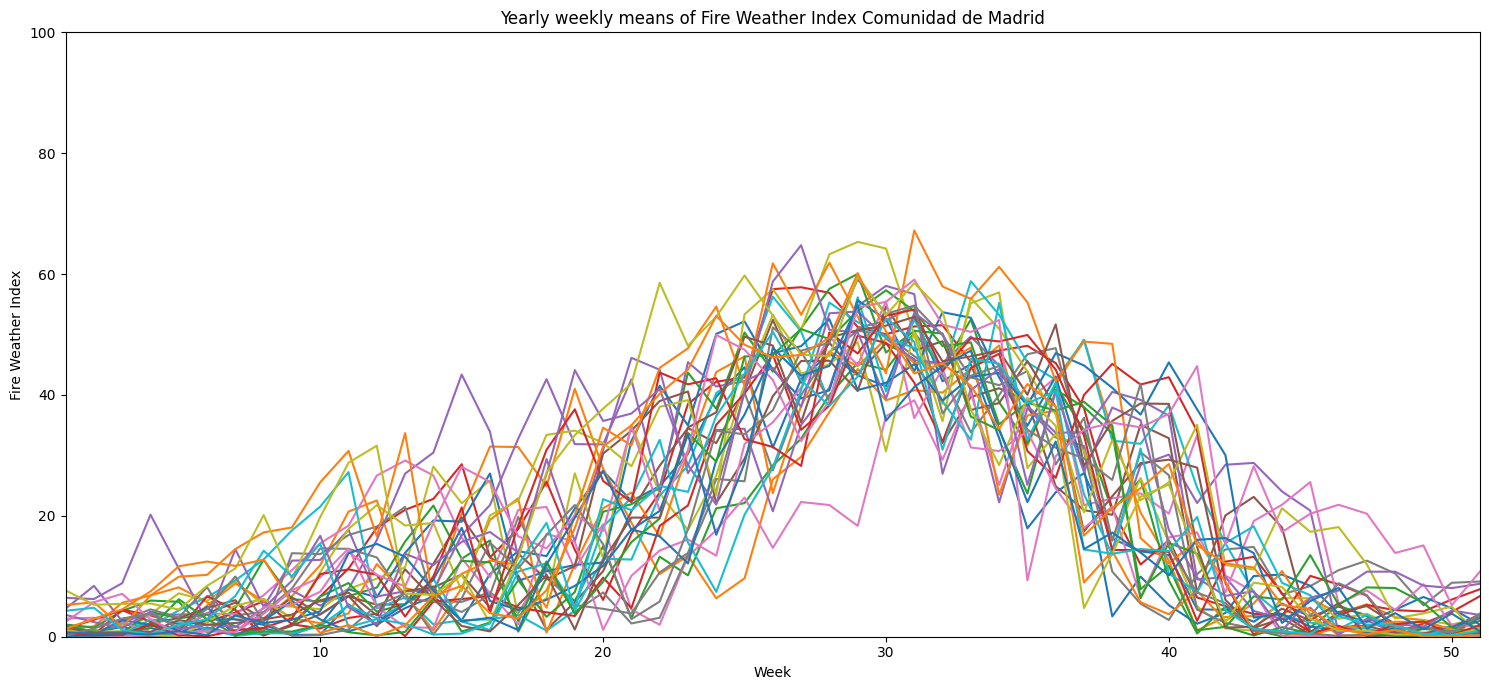

In [29]:
fig, ax = plt.subplots(1, figsize=(15, 7),dpi=100)
for i,year in enumerate(range(1991, 2023)):
    plt.plot(weekly_clim.sel(time=slice(f'{year}-01-01',f'{year}-12-31'))[0:52], label=year)
ax.set_xlabel('Week')
ax.set_ylabel('Fire Weather Index')
plt.ylim(ymax=100,ymin=0)  # this line
plt.xlim(xmax=51,xmin=1)
plt.title(f'Yearly weekly means of Fire Weather Index {location.raw["address"].get("state")}')
plt.tight_layout()